<a href="https://colab.research.google.com/github/pedroescobedob/Song-likability-Prediction/blob/master/Song_likability_Prediction_by_Pedro_Escobedo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install shap
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install kaggle
!pip install eli5
!pip install pdpbox
!pip install pydotplus
!pip install graphviz

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383176 sha256=e19e8c53e2ee8b0dad2b8b6d0f772c0ca7d3cd8b683f03018726ff00c1ea2e33
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap
     |████████████████████████████████| 102kB 2.3MB/s 
     |████████████████████████████████| 153kB 2.7MB/s 
     |████████████████████████████████| 614kB 44.1MB/s 
     |████████████████████████████████| 235kB 60.4MB/s 
     |████████████████████████████████| 307kB 49.5MB/s 
     |████████████████████████████████| 215kB 57.9MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 737kB 52.9MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.4.0-py2.py3-none-any.whl size=195587 sha256=d6a9828b106b6b97acfe57ef686190d1f809689cb019941

     |████████████████████████████████| 112kB 2.7MB/s 
     |████████████████████████████████| 57.7MB 62kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=9f5c139b91897a768e3e7dd11e8274e1c2080cf4c541dcec18cf7cb841d1372c
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [0]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from ipywidgets import interact, fixed
from xgboost import XGBRegressor, XGBClassifier
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import eli5
from eli5.sklearn import PermutationImportance
import category_encoders as ce
import shap

Using TensorFlow backend.


In [0]:
from google.colab import files
uploaded = files.upload()

Saving Spotify_data.csv to Spotify_data (1).csv


# Data Exploration

In [0]:
df = pd.read_csv('Spotify_data.csv')
print(df.shape)
df.head()

(2017, 17)


,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [0]:
df = df.drop(columns='Unnamed: 0')

In [0]:
df.isnull().any()

acousticness        False
danceability        False
duration_ms         False
energy              False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
speechiness         False
tempo               False
time_signature      False
valence             False
target              False
song_title          False
artist              False
dtype: bool

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 16 columns):
acousticness        2017 non-null float64
danceability        2017 non-null float64
duration_ms         2017 non-null int64
energy              2017 non-null float64
instrumentalness    2017 non-null float64
key                 2017 non-null int64
liveness            2017 non-null float64
loudness            2017 non-null float64
mode                2017 non-null int64
speechiness         2017 non-null float64
tempo               2017 non-null float64
time_signature      2017 non-null float64
valence             2017 non-null float64
target              2017 non-null int64
song_title          2017 non-null object
artist              2017 non-null object
dtypes: float64(10), int64(4), object(2)
memory usage: 252.2+ KB


In [0]:
df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


# Split data into train, test, val

In [0]:
# Train, test split
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['target'], random_state=42)

In [0]:
# Train, val split
train, val = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['target'], random_state=42)

In [0]:
train.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
721,0.34400,0.690,237040,0.737,0.000000,1,0.243,-4.123,1,0.0363,115.020,4.0,0.821,1,I Blame Myself,Sky Ferreira
1035,0.01650,0.443,223800,0.804,0.000003,10,0.181,-6.432,1,0.0406,151.928,4.0,0.437,0,Hurricane,Luke Combs
935,0.05990,0.756,257053,0.853,0.000562,9,0.115,-5.920,0,0.0525,100.004,4.0,0.426,1,By Design,Kid Cudi
533,0.00814,0.401,93267,0.972,0.878000,0,0.382,-2.236,1,0.0886,152.839,4.0,0.405,1,No Ass,FIDLAR
1124,0.80300,0.612,245493,0.570,0.000033,1,0.122,-9.620,0,0.0735,169.842,4.0,0.813,0,Tú Sí Sabes Quererme,Natalia Lafourcade


# Setting up features / train, test, val

In [0]:
# Target
target = 'target'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [0]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1613, 13), (1613,), (404, 13), (404,), (404, 13), (404,))

# Modeling

In [0]:
# Random Forest with Ordinal Encoder
random_forest = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

random_forest.fit(X_train, y_train)
print('Validation Accuracy:', random_forest.score(X_val, y_val), 
      '\nTest Accuracy:', random_forest.score(X_test, y_test))

Validation Accuracy: 0.7623762376237624 
Test Accuracy: 0.7623762376237624


In [0]:
# Using eli5 to find permutation importances

# transforming data for permuter
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

# setting model
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# setting permuter to permutation importance
permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=3,
    random_state=42
)

# fitting the data
permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.0974 ± 0.0592,instrumentalness
0.0454 ± 0.0163,speechiness
0.0314 ± 0.0062,danceability
0.0264 ± 0.0142,duration_ms
0.0248 ± 0.0070,energy
0.0198 ± 0.0162,acousticness
0.0182 ± 0.0187,loudness
0.0182 ± 0.0023,key
0.0165 ± 0.0199,liveness
0.0157 ± 0.0084,valence


# Receiver Operating Characteristic (ROC)

In [0]:
# ROC Score

y_pred_proba = random_forest.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.8357107843137255

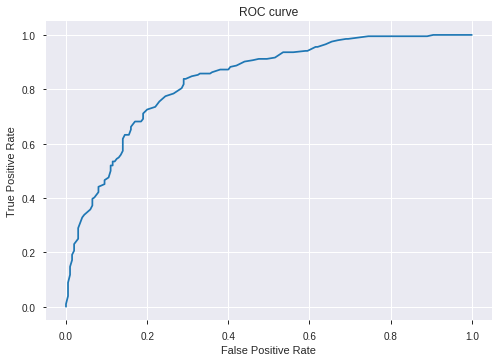

In [0]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val==1, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

## Confusion Matrix

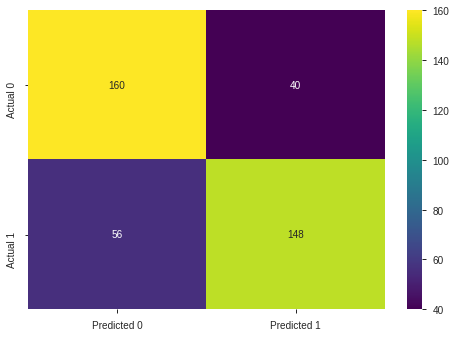

In [0]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

y_pred = random_forest.predict(X_test)
plot_confusion_matrix(y_val, y_pred);

# XGBoost Classifier with Ordinal Encoding

In [0]:
xgboost = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

xgboost.fit(X_train, y_train)
print('Validation Accuracy:', xgboost.score(X_val, y_val), 
      '\nTest Accuracy:', xgboost.score(X_test, y_test))

Validation Accuracy: 0.7277227722772277 
Test Accuracy: 0.7277227722772277


# Visualizations

In [0]:
# Features and labels for exploratory data analysis

target = 'target'
features = train.columns.drop([target])

X = train[features]
y = train[target]

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


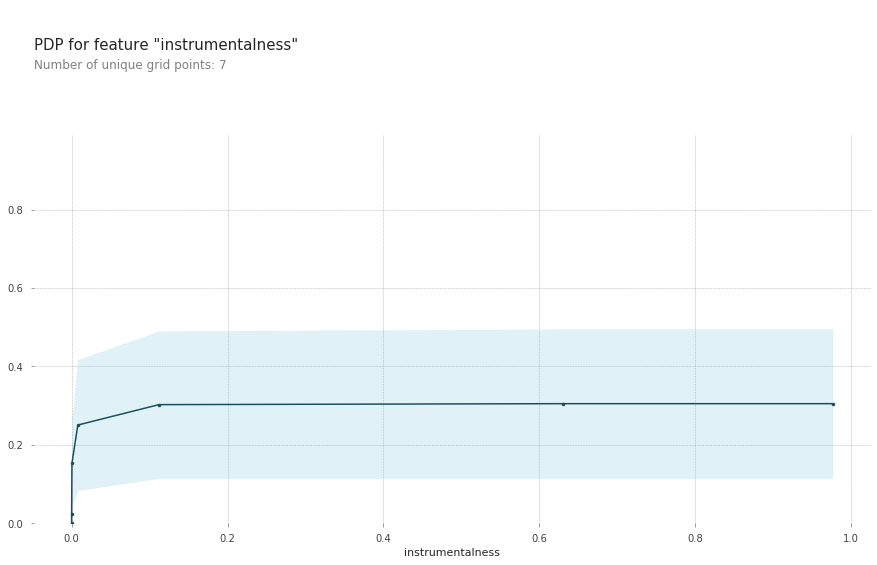

In [0]:
from pdpbox import pdp

feature = 'instrumentalness'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

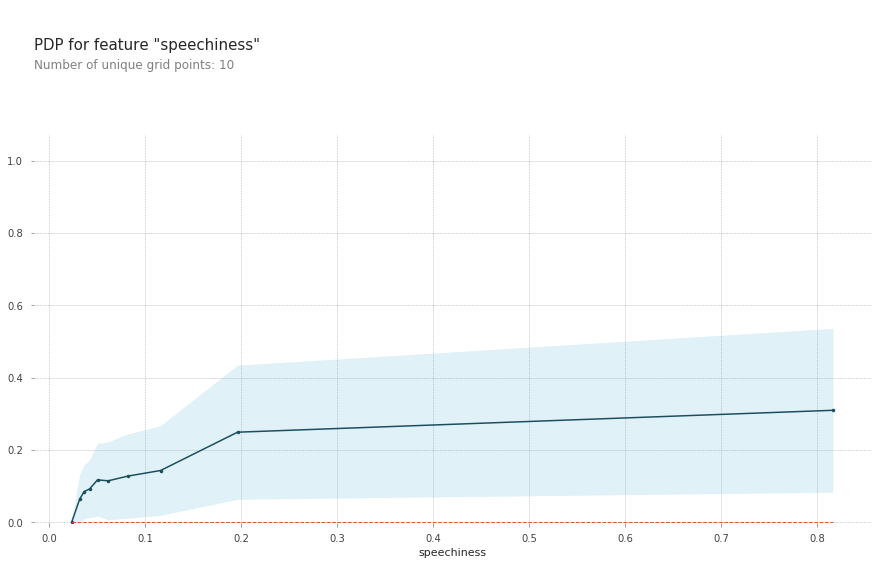

In [0]:
feature = 'speechiness'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


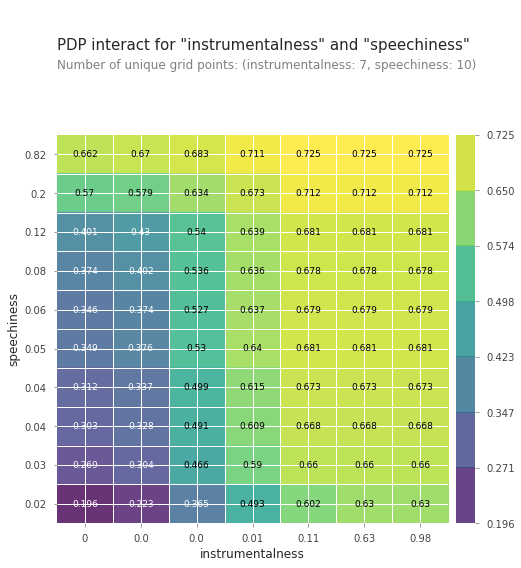

In [0]:
features = ['instrumentalness', 'speechiness']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

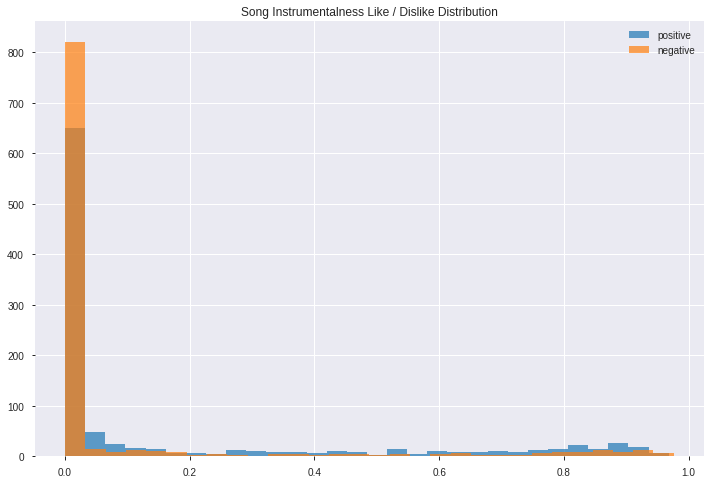

In [0]:
# Histogram
# Distribution of like dislike based on instrumentalness
pos_instrumentalness = df[df['target'] == 1]['instrumentalness']
neg_instrumentalness = df[df['target'] == 0]['instrumentalness']
fig = plt.figure(figsize=(12, 8))
plt.title('Song Instrumentalness Like / Dislike Distribution')
pos_instrumentalness.hist(alpha = 0.7, bins=30, label='positive')
neg_instrumentalness.hist(alpha = 0.7, bins=30, label='negative')
plt.legend(loc='upper right')

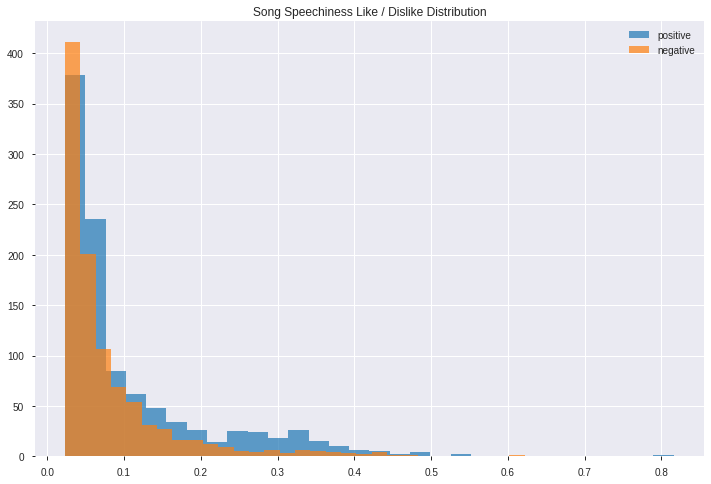

In [0]:
# Histogram
pos_speechiness = df[df['target'] == 1]['speechiness']
neg_speechiness = df[df['target'] == 0]['speechiness']
fig = plt.figure(figsize=(12, 8))
plt.title('Song Speechiness Like / Dislike Distribution')
pos_speechiness.hist(alpha = 0.7, bins=30, label='positive')
neg_speechiness.hist(alpha = 0.7, bins=30, label='negative')
plt.legend(loc='upper right')